In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Temporal Fusion Transformer (TFT)
Darts’ TFTModel incorporates the following main components from the original Temporal Fusion Transformer (TFT) architecture as outlined in this paper:

gating mechanisms: skip over unused components of the model architecture

variable selection networks: select relevant input variables at each time step.

temporal processing of past and future input with LSTMs (long short-term memory)

multi-head attention: captures long-term temporal dependencies

prediction intervals: per default, produces quantile forecasts instead of deterministic values

## Training
TFTModel can be trained with past and future covariates. It is trained sequentially on fixed-size chunks consisting of an encoder and a decoder part:

encoder: past input with input_chunk_length

past target: mandatory

past covariates: optional

decoder: future known input with output_chunk_length

future covariates: mandatory (if none are available, consider TFTModel’s optional arguments add_encoders or add_relative_index from here)

In each iteration, the model produces a quantile prediction of shape (output_chunk_length, n_quantiles) on the decoder part.

# Forecast
## Probabilistic Forecast
Per default, TFTModel produces probabilistic quantile forecasts using QuantileRegression. This gives the range of likely target values at each prediction step. Most deep learning models in Darts’ - including TFTModel - support QuantileRegression and 16 other likelihoods to produce probabilistic forecasts by setting likelihood=MyLikelihood() at model creation.

To produce meaningful results, set num_samples >> 1 when predicting. For example:

model.predict(*args, **kwargs, num_samples=200)
Predictions with forecasting horizon n are generated auto-regressively using encoder-decoder chunks of the same size as during training.

If n > output_chunk_length, you have to supply additional future values for the covariates you passed to model.train().

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [3]:
 #before starting, we define some constants
num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

# Air Passenger Example
This data set that is highly dependent on covariates. Knowing the month tells us a lot about the seasonal component, whereas the year determines the effect of the trend component.

Additionally, let’s convert the time index to integer values and use them as covariates as well.

All of the three covariates are known in the future, and can be used as future_covariates with the TFTModel.

In [4]:
# Read data
series = AirPassengersDataset().load()

# we convert monthly number of passengers to average daily number of passengers per month
series = series / TimeSeries.from_series(series.time_index.days_in_month)
series = series.astype(np.float32)

# Create training and validation sets:
training_cutoff = pd.Timestamp("19571201")
train, val = series.split_after(training_cutoff)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)


# Create a model
If you want to produce deterministic forecasts rather than quantile forecasts, you can use a PyTorch loss function (i.e., set loss_fn=torch.nn.MSELoss() and likelihood=None).

The TFTModel can only be used if some future input is given. Optional parameters add_encoders and add_relative_index can be useful, especially if we don’t have any future input available. They generate encoded temporal data that is used as future covariates.

Since we already have future covariates defined in our example they are commented out.

In [5]:
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 24
forecast_horizon = 12
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
    #pl_trainer_kwargs={
      #"accelerator": "gpu", 
      #"devices": [0]
    #},
)

# Train the TFT
In what follows, we can just provide the whole covariates series as future_covariates argument to the model; the model will slice these covariates and use only what it needs in order to train on forecasting the target train_transformed:

In [6]:
my_model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)

Training: |                                               | 0/? [00:00<?, ?it/s]

TFTModel(output_chunk_shift=0, hidden_size=64, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=24, output_chunk_length=12, batch_size=16, n_epochs=300, add_encoders=None, random_state=42)

# Look at predictions on the validation set
We perform a one-shot prediction of 24 months using the “current” model - i.e., the model at the end of the training procedure:

Predicting: |                                             | 0/? [00:00<?, ?it/s]

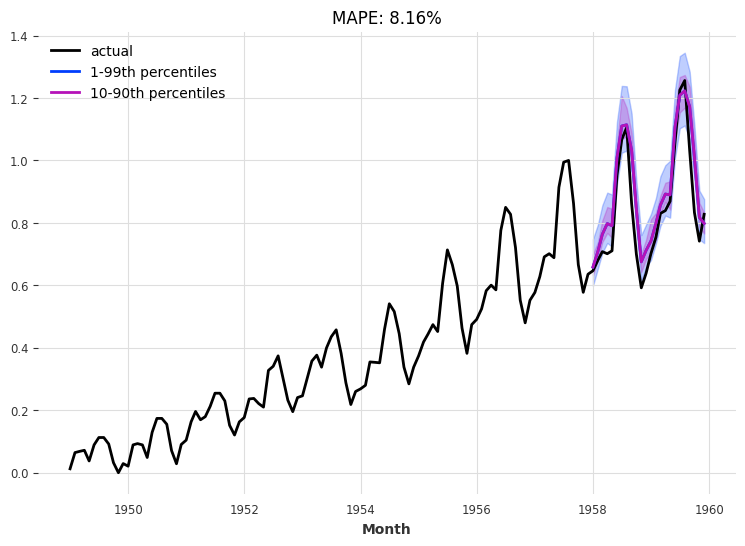

In [7]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()


eval_model(my_model, 24, series_transformed, val_transformed)

# Backtesting
Let’s backtest our TFTModel model, to see how it performs with a forecast horizon of 12 months over the last 3 years:

In [8]:
backtest_series = my_model.historical_forecasts(
    series_transformed,
    future_covariates=covariates_transformed,
    start=train.end_time() + train.freq,
    num_samples=num_samples,
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,
    last_points_only=False,
    retrain=False,
    verbose=True,
)


Predicting: |                                             | 0/? [00:00<?, ?it/s]

MAPE: 5.72%


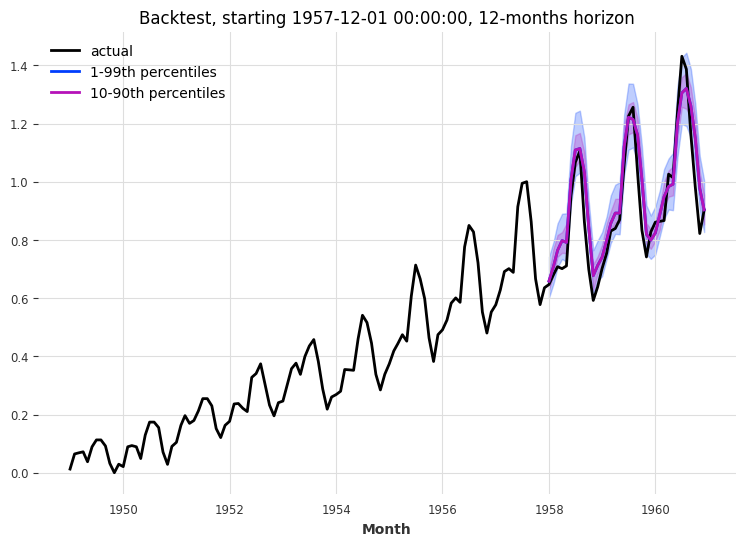

In [9]:
def eval_backtest(backtest_series, actual_series, horizon, start, transformer):
    plt.figure(figsize=figsize)
    actual_series.plot(label="actual")
    backtest_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    backtest_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)
    plt.legend()
    plt.title(f"Backtest, starting {start}, {horizon}-months horizon")
    print(
        "MAPE: {:.2f}%".format(
            mape(
                transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series),
            )
        )
    )


eval_backtest(
    backtest_series=concatenate(backtest_series),
    actual_series=series_transformed,
    horizon=forecast_horizon,
    start=training_cutoff,
    transformer=transformer,
)

In [13]:
from darts.explainability import TFTExplainer

In [14]:
explainer = TFTExplainer(my_model)

In [15]:
explainability_result = explainer.explain()

Predicting: |                                             | 0/? [00:00<?, ?it/s]

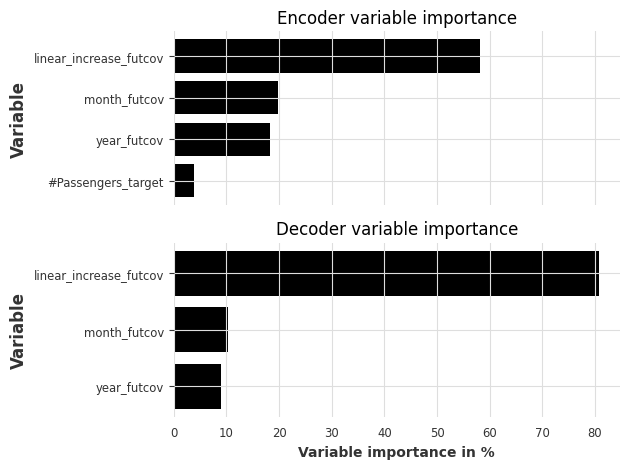

In [16]:
explainer.plot_variable_selection(explainability_result)

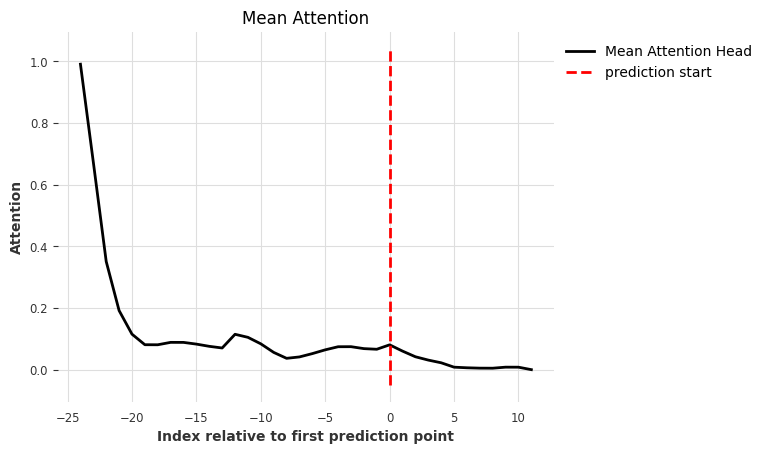

<Axes: title={'center': 'Mean Attention'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [17]:
explainer.plot_attention(explainability_result, plot_type="time")

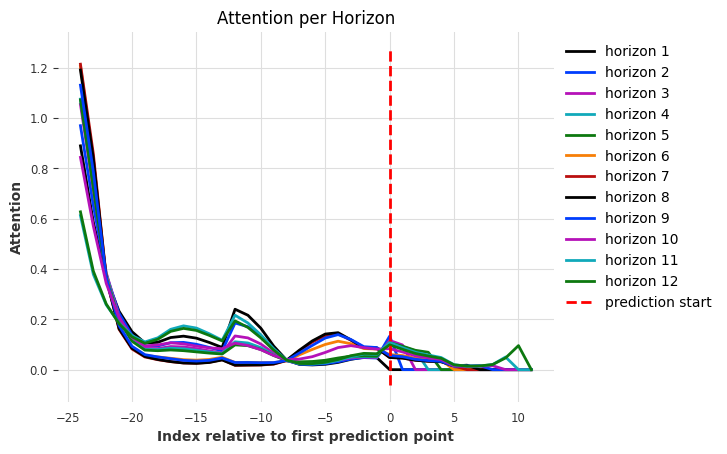

<Axes: title={'center': 'Attention per Horizon'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [18]:
explainer.plot_attention(explainability_result, plot_type="all")

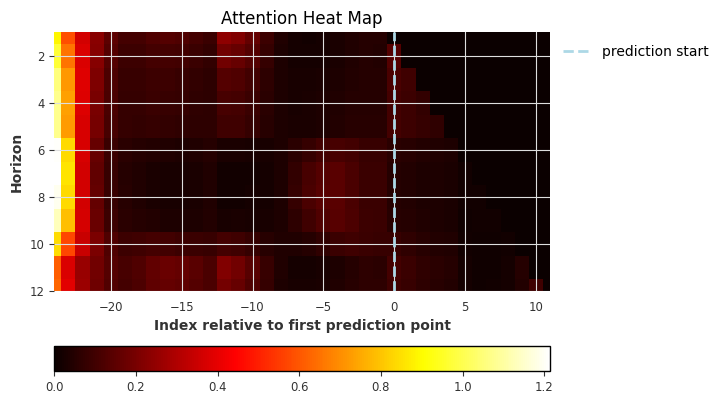

<Axes: title={'center': 'Attention Heat Map'}, xlabel='Index relative to first prediction point', ylabel='Horizon'>

In [19]:
explainer.plot_attention(explainability_result, plot_type="heatmap")

In [20]:
explainability_result.get_encoder_importance()

,#Passengers_target,year_futcov,month_futcov,linear_increase_futcov
0,3.9,18.199999,19.799999,58.099998


In [21]:
explainability_result.get_decoder_importance()

,year_futcov,month_futcov,linear_increase_futcov
0,9.0,10.3,80.699997


In [22]:
explainability_result.get_static_covariates_importance()

""


<Axes: xlabel='Month'>

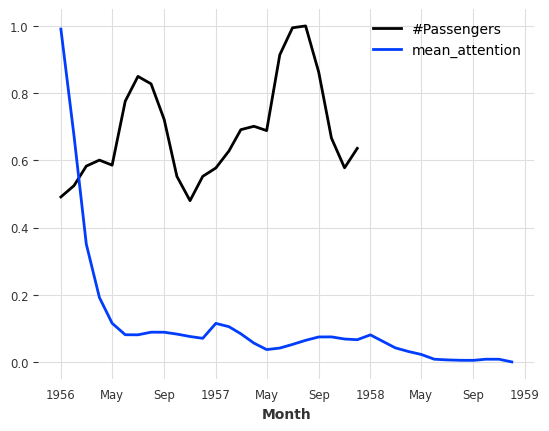

In [25]:
attention = explainability_result.get_attention().mean(axis=1)

time_intersection = train_transformed.time_index.intersection(attention.time_index)

train_transformed[time_intersection].plot()
attention.plot(label="mean_attention", max_nr_components=12)